# Deep Learning for Text Classification
---
<small><i>February 2023 - *Notebook created by Mariona Carós


In this lab you are going to train several deep learning models for text classification. As you know, the goal of text classification is given a piece of text and a label, learning a model that is able to predict labels from text.

Take for example a simple **Sentiment Analysis** problem. For this problem let's consider texts that belong to movie reviews. **These reviews can be classified on positive or negative**.

First, we are going to import and install some of the libraries we will need.

In [ ]:
# We import the libraries that we are going to use
import os
import shutil
import string
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import spacy
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm_notebook
import time
from sklearn import metrics
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# workaround for solving UTF-8 error of colab
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

Here we download the language model from Spacy that we are going to use.

In [ ]:
# Mind the ! sign at the beginning of the command that indicates that it belongs to a command line call.
! python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Dataset

We download the IMDB dataset from the web page with the `wget` command line tool. The IMDB dataset includes 50K movie reviews for natural language processing or text analytics. This is a dataset for binary sentiment classification, which includes a set of 25,000 movie reviews for training and 25,000 for testing.

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xzf aclImdb_v1.tar.gz
!ls aclImdb/

# remove unnecessary files from the dataset
shutil.rmtree('aclImdb/train/unsup')

--2024-05-15 09:02:23--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  5.41MB/s    in 10s     

2024-05-15 09:02:34 (7.97 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

imdbEr.txt  imdb.vocab	README	test  train


### Data Preprocessing

We load a pre-trained language model for the English language. Specifically, the `"en_core_web_lg"` model is being loaded, which is a large-sized language model trained on web text.

In [ ]:
# Load Spacy language model
nlp = spacy.load("en_core_web_lg")


We define our preprocessing functions for removing HTML codes, converting to lowercase, lemmatizing, and removing stop words and punctuation.

In [ ]:
# Creating our tokenizer function
def spacy_tokenizer(doc, texts, file_names, label, i):
    """
    Lemmatize each token
    Convert each token into lowercase
    Remove stop words
    Modify integer numbers into word 'number'
    Store word vectors
    """
    clean_tokens = []
    vectors=[]

    for word in doc:

      if word.like_num:
        lemma='number'
        clean_tokens.append(lemma)
        #store vectors
        vectors.append(nlp(lemma).vector)

      elif not word.is_punct and not word.is_stop and len(str(word)) > 1:
        lemma = word.lemma_.lower()
        clean_tokens.append(lemma)
        vectors.append(word.vector)

    file_data = {
        "file_name": file_names[i],
        "label": label,
        "text": texts[i],
        "clean_tokens":clean_tokens,
        "vectors": vectors,
        "mean_vector":np.mean(vectors, axis=0)
    }

    return file_data


In [ ]:
def read_file(filename, reviews_dir):
  """
  read file and remove HTML tags
  """
  with open(os.path.join(reviews_dir, filename), 'r', encoding='UTF-8') as f:
    text = f.read()
    tags_del = BeautifulSoup(text, "lxml").get_text()

  return tags_del

In [ ]:
def load_data(is_train, is_neg = True, max_files=None):
  """
  Input arguments: is_train (boolean), is_neg (optional boolean, default value
  is True), max_files (integer)
  Output: A list of dictionaries, where each dictionary contains information
  about a single review.

  The function reads all files in the specified directory, preprocesses the text
  by removing HTML tags, converting to lowercase, lemmatizing, and removing stop
  words and punctuation. It then creates a dictionary for each review, which
  contains the file name, label (0 for negative reviews, 1 for positive reviews),
  original text, and preprocessed tokens. The function returns a list of these
  dictionaries.
  """
  start_time = time.time()

  if is_train:
      base_dir = 'aclImdb/train'
  else:
      base_dir = 'aclImdb/test'
  if is_neg:
      subdir = 'neg'
      label = 0
  else:
      subdir = 'pos'
      label = 1

  reviews_dir = os.path.join(base_dir,subdir)
  file_names = sorted(os.listdir(reviews_dir))

  if max_files is not None:
      file_names = file_names[:max_files]

  texts = [read_file(filename, reviews_dir) for filename in file_names]
  # Spacy NLP
  docs = list(nlp.pipe(texts, disable=["parser", "ner", "senter"]))
  reviews = [spacy_tokenizer(doc, texts, file_names, label, i) for i,doc in enumerate(docs)]

  print("Load data time: %s min" % (round((time.time() - start_time) / 60, 3)))
  return reviews


In [ ]:
# Loading data, pacience this takes time
train_neg_reviews = load_data(is_train=True, max_files = 5000)
train_pos_reviews = load_data(is_train=True, is_neg=False, max_files = 5000)
test_neg_reviews = load_data(is_train=False, max_files = 1000)
test_pos_reviews = load_data(is_train=False, is_neg=False, max_files = 1000)

Load data time: 3.003 min
Load data time: 3.002 min
Load data time: 0.569 min
Load data time: 0.586 min


In [ ]:
# Show text
train_neg_reviews[0]['text']

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [ ]:
# Show clean tokens
' '.join(train_neg_reviews[0]['clean_tokens'])


'story man unnatural feeling pig start opening scene terrific example absurd comedy formal orchestra audience turn insane violent mob crazy chanting singer unfortunately stay absurd time general narrative eventually make putting era turn cryptic dialogue shakespeare easy number grader technical level well think good cinematography future great vilmos zsigmond future star sally kirkland frederic forrest see briefly'

Let's build dataframes for better data manipulation.

In [ ]:
# Build DataFrames for training and testing
train_data = pd.DataFrame(train_pos_reviews+train_neg_reviews).sample(frac = 1)
test_data = pd.DataFrame(test_pos_reviews+test_neg_reviews).sample(frac = 1)


In [ ]:
# Add clean_tokens as a string
train_data['clean_texts'] = train_data.apply(lambda row: ' '.join(row['clean_tokens']), axis=1)
test_data['clean_texts'] = test_data.apply(lambda row: ' '.join(row['clean_tokens']), axis=1)

In [ ]:
train_data.head()

,file_name,label,text,clean_tokens,vectors,mean_vector,clean_texts
9222,2550_1.txt,0,"It was the tag-line ""in the tradition of Ameri...","[tag, line, tradition, american, pie, fool, re...","[[-0.68064, 7.0798, 3.7319, -2.5934, 8.1413, 1...","[-0.7510977, 0.51795536, -1.2827002, -0.726730...",tag line tradition american pie fool rent movi...
4410,271_10.txt,1,It's all about Mitzi. I loved her in this. And...,"[mitzi, love, look, fantastic, love, lifetime,...","[[0.32252, 0.4749, -1.5764, -0.47933, -1.3597,...","[-0.4529741, -0.074245594, -1.7933736, -1.2653...",mitzi love look fantastic love lifetime sunday...
4937,3194_9.txt,1,"There has never been anything like it, that's ...","[like, sure, episodic, seemingly, redundant, t...","[[-2.3334, -1.3695, -1.133, -0.68461, -1.8482,...","[-0.46072513, 0.42707735, -1.2368827, -0.66611...",like sure episodic seemingly redundant trilogy...
7396,12157_1.txt,0,I couldn't believe this terrible movie was act...,"[believe, terrible, movie, actually, bad, acto...","[[0.087598, 1.5972, -1.0649, -0.39302, 0.22907...","[-0.5629624, 0.5780861, -1.6523788, -0.9942712...",believe terrible movie actually bad actor find...
5009,10008_2.txt,0,The film is bad. There is no other way to say ...,"[film, bad, way, story, weak, outdated, especi...","[[-6.2225, -1.0184, -3.9655, -9.4876, -2.0239,...","[-0.65270346, 0.48410276, -1.8053297, -1.06038...",film bad way story weak outdated especially co...


In [ ]:
len(train_data)

10000

In [ ]:
test_data.head()

,file_name,label,text,clean_tokens,vectors,mean_vector,clean_texts
1733,10660_4.txt,0,I do not like Himesh Reshamiya. I do not like ...,"[like, himesh, reshamiya, like, singing, song,...","[[-2.3334, -1.3695, -1.133, -0.68461, -1.8482,...","[-0.2764752, 0.90588945, -1.3796914, -1.165023...",like himesh reshamiya like singing song craze ...
463,10417_7.txt,1,Despite its New York setting & New York charac...,"[despite, new, york, setting, new, york, chara...","[[-2.2872, -1.9349, 1.0128, -0.95223, 7.1268, ...","[-0.7659505, -0.512257, -1.0389585, -0.6119779...",despite new york setting new york character su...
1604,10544_3.txt,0,"The Toxic Avenger, hideously deformed creature...","[toxic, avenger, hideously, deformed, creature...","[[-0.78919, -2.7074, 1.6015, 0.91893, 0.22646,...","[-0.81105894, -0.13827471, -0.3047374, 0.07012...",toxic avenger hideously deformed creature supe...
1036,10032_1.txt,0,"I walked into a book store in Brentwood, Tenne...","[walk, book, store, brentwood, tennessee, go, ...","[[0.47171, 0.36651, -1.7973, -1.7215, -1.2233,...","[-0.4931361, 0.15395425, -1.9893007, -1.510994...",walk book store brentwood tennessee go dedicat...
1568,10511_1.txt,0,"It's 2005, my friends...a time of amazing spec...","[number, friend, time, amazing, special, effec...","[[-1.2778, -0.25356, 1.1077, 3.7485, 4.5726, 3...","[-0.5647604, 0.4712712, -1.9082327, -1.5345925...",number friend time amazing special effect age ...


In [ ]:
len(test_data)

2000

## Word Vectors

The first step that we need to take, after cleaning our data is to get a numerical **representation of our input text**. This process, sometimes called *vectorization*, consists on having a vector, or embedding, that represents the full sentence.

In this case, we are using **word2vec**, which means that we are obtaining a vector for each of the words, or tokens. Then, to obtain a representation of the full text we need to combine this representation at a word level into the final one that represents the whole sentence. Good news, this has been already done in the data preprocessing and you already have the average vector representation in the column `mean_vector`

What do Word Vectors Look Like?

In [ ]:
## TODO: Print a word vector
word_vector = train_data["mean_vector"][0]
print(word_vector)

[-5.8133686e-01  3.9267543e-01 -9.1543037e-01 -3.3432341e-01
  1.7519240e+00  4.0109390e-01  2.1471763e+00  2.0679374e+00
 -1.4584647e+00 -7.3070562e-01  3.0722411e+00  4.0940163e-01
 -2.2273650e+00  1.4512004e+00 -1.1648331e-01  4.7284278e-01
  8.2097971e-01  2.5608036e-01 -1.2124937e+00  8.4686464e-01
  3.0783245e-01 -1.2472592e-01  3.5336888e-01 -4.6853754e-01
  1.3735808e+00 -2.0827535e-01 -1.0529712e+00  1.9229467e-01
  9.3068963e-01  1.9580910e+00  4.3538779e-01  1.2509470e+00
 -3.3042607e-01 -1.6329470e+00 -1.2574549e+00  5.3420025e-01
  1.4617948e-01  2.9261532e-01  4.1457906e-01  7.0617028e-02
 -4.5003304e-01  2.1793337e-01 -4.2098284e-01  1.3754324e+00
 -1.5130879e+00 -1.3083547e-01  1.7063925e-01 -1.9838734e+00
  1.2478180e+00  1.0106833e-01 -7.4293911e-01  1.6672587e+00
 -1.3598197e+00 -2.0702534e+00  4.5524979e-01  9.2777210e-01
 -5.0119811e-01  8.8177994e-02  1.4646734e+00  8.4497631e-02
  2.8507510e-01  5.9607011e-01 -9.1170388e-01 -3.3667302e-01
  1.9950970e+00  1.28449

**What is the dimension of the word vectors?** You will need it to define the embedding layer dimension.

In [ ]:
## TODO Get vector dimension
vec_dim = len(train_data["mean_vector"][0])
vec_dim

300

Be sure the vector dimension is correct.

Next, by using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), we are going to visualize the word vectors of a sentence in a 2D space.

In [ ]:
# TODO Show clean tokens of review number 3
n=3
train_data["clean_tokens"][n-1] # python indexing starts with 0, so 2 is the index of the third

['brilliant',
 'acting',
 'lesley',
 'ann',
 'warren',
 'well',
 'dramatic',
 'hobo',
 'lady',
 'see',
 'love',
 'scene',
 'clothe',
 'warehouse',
 'number',
 'corn',
 'face',
 'classic',
 'good',
 'blazing',
 'saddle',
 'lawyer',
 'superb',
 'accuse',
 'turncoat',
 'sell',
 'boss',
 'dishonest',
 'lawyer',
 'pepto',
 'bolt',
 'shrug',
 'indifferently',
 'lawyer',
 'say',
 'number',
 'funny',
 'word',
 'jeffrey',
 'tambor',
 'favorite',
 'later',
 'larry',
 'sanders',
 'fantastic',
 'mad',
 'millionaire',
 'want',
 'crush',
 'ghetto',
 'character',
 'malevolent',
 'usual',
 'hospital',
 'scene',
 'scene',
 'homeless',
 'invade',
 'demolition',
 'site',
 'time',
 'classic',
 'look',
 'leg',
 'scene',
 'number',
 'big',
 'digger',
 'fight',
 'number',
 'bleed',
 'movie',
 'get',
 'well',
 'time']

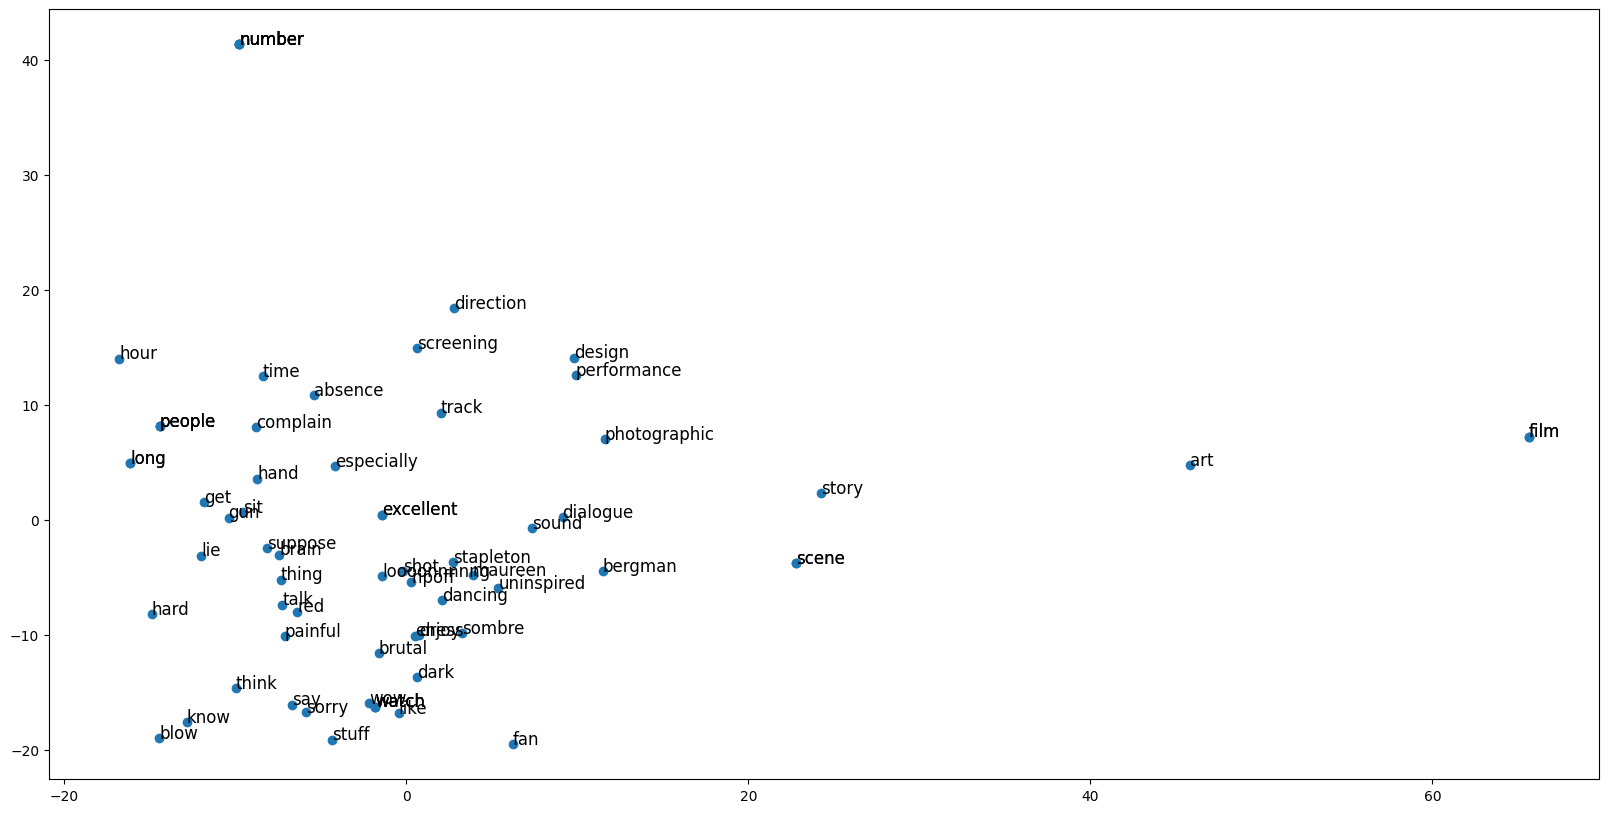

In [ ]:
# create a scatter plot of the projection

from sklearn.decomposition import PCA
from matplotlib import pyplot

X = train_neg_reviews[n]['vectors']
pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.figure(figsize=(20, 10))
pyplot.scatter(result[:, 0], result[:, 1])

words = list(train_neg_reviews[n]['clean_tokens'])
for i, word in enumerate(words):
  pyplot.annotate(word, xy=(result[i, 0], result[i, 1]),fontsize=12)
pyplot.show()

You can obtain the **cosine similarity** between two words by **obtaining their doc object** and using `similarity` method.

In [ ]:
train_data["clean_tokens"][0][0]

'bromwell'

In [ ]:
train_data["clean_tokens"][2][10]

'love'

In [ ]:
## TODO compute similarity for 2 similar words by using the cosine similarity
word_1="bromwell"
word_2="love"

word_1_vector = train_data["vectors"][0][0]

word_2_vector = train_data["vectors"][2][10]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Example vectors
word_1_vector = word_1_vector.reshape(1, -1)
word_2_vector = word_2_vector.reshape(1, -1)

similarity = cosine_similarity(word_1_vector, word_2_vector)
similarity

array([[-0.05608653]], dtype=float32)

If you have curiosity you can visualize word embeddings of another review.


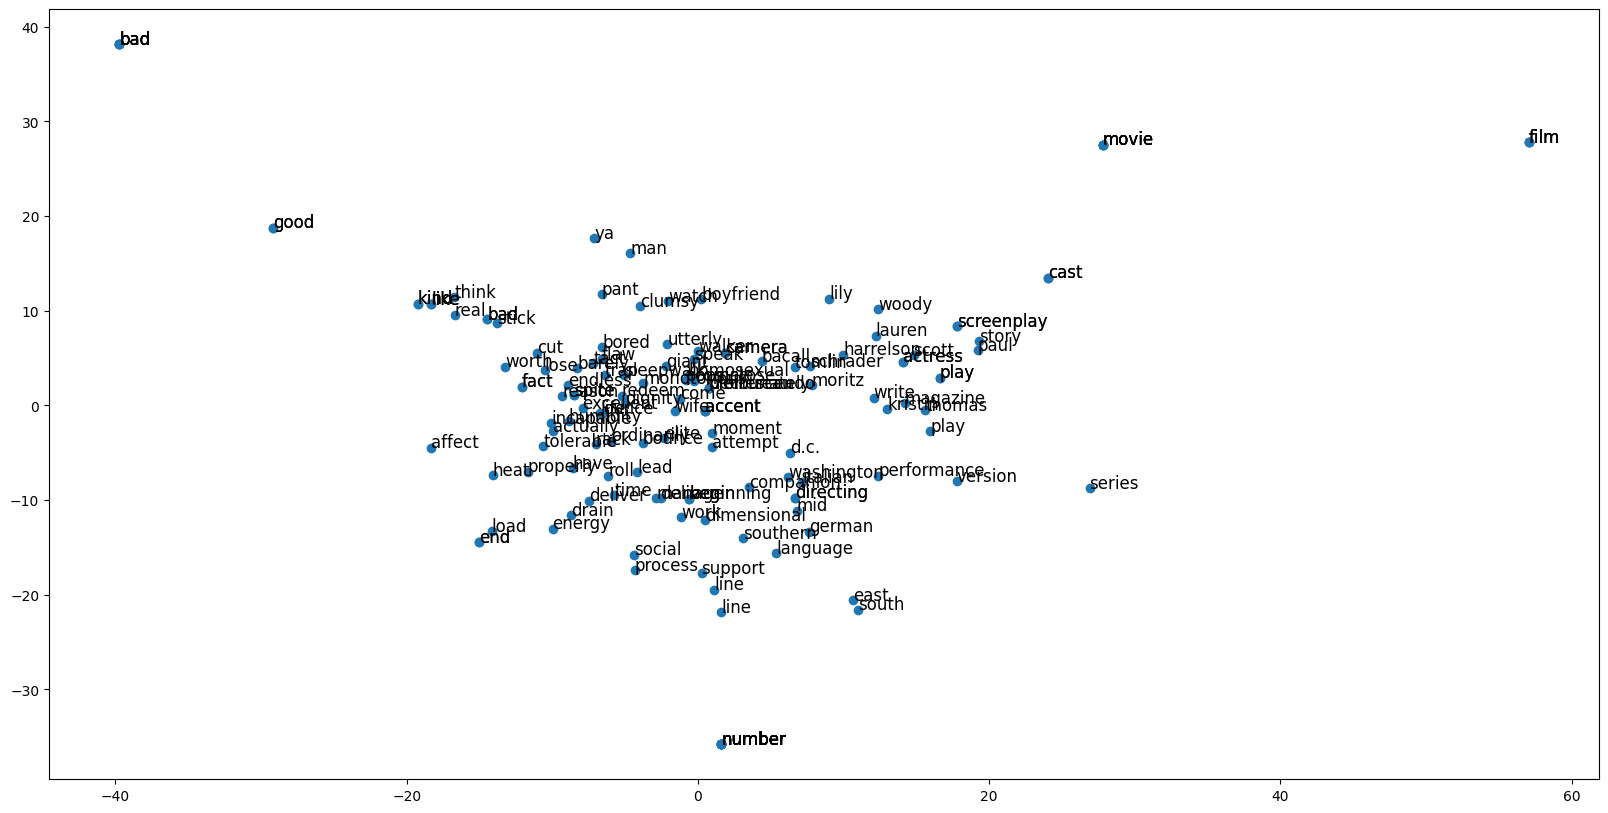

In [ ]:
n=10
X = train_neg_reviews[n]['vectors']
pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.figure(figsize=(20, 10))
pyplot.scatter(result[:, 0], result[:, 1])

words = list(train_neg_reviews[n]['clean_tokens'])
for i, word in enumerate(words):
  pyplot.annotate(word, xy=(result[i, 0], result[i, 1]),fontsize=12)
pyplot.show()

## **Basic classification structure**
Usually a text classifier has these basic components:

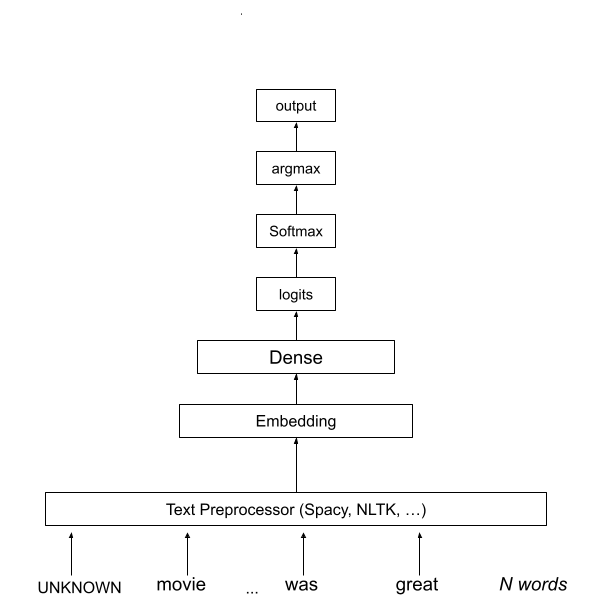




* **Text prepocessor**: this step usually includes preprocessing tasks like transforming to lower case, removing stop words, removing HTML, etc. It has to be carefully designed depending on each use case, as it might have a high impact on the performance of the model.
* **Vectorizer**: the component that given a string of text transforms it into a vector. This is what we call the **embedding** of the text.
* **Classification network**: a neural network that aims to codify the embedding into the output classes. The result of this component is what we call the logits.
* **Model output**: a disptribution of probabilities across the classes, usually after applying a softmax transformation.


There are **different approaches** for solving this problem. From a very simple approach based on the scikit learn framework to the most advanced **transformer** based model, all of them follow the described architecture. **Differences come in how the embedding is obtained**.

## **Fully Connected Neural Network**

Let's implement a dense neural network for text classification by using word vectors taking the following considerations:

* The input shape is the vector dimension
* The neural network should be composed of  4 `Dense` layers with the following shape: `[500, 300, 250, 100]` and a last layer for classification.
* The last dense layer should output a probability value between 0 and 1 for binary classification.
* For the activation functions of intermediate layers you can chose between `tanh` and `relu`.
* `Dropout` is usually used after the activation function to avoid overfitting. A typical value for dense layers is 0.5.

*You can check the [Keras documentation here](https://keras.io/api/layers/core_layers/dense/) for the definition of the model.*


In [ ]:
from keras import regularizers, optimizers
from keras.layers import TextVectorization
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, GlobalMaxPool1D
from keras.models import Sequential
from keras.initializers import Constant
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# Assuming input_shape is the dimension of your word vectors
input_shape = (300,)

# we create a new sequential model object
model = Sequential()

# Add Dense layers with specified shapes and activation functions
model.add(Dense(500, input_shape=input_shape, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(300, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.5))

# Output layer for binary classification with 'sigmoid' activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               150500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               75250     
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               2

Here we are going to define the optimizer, the learning rate and the loss.

The **learning rate** is a hyperparameter used in many machine learning algorithms, such as gradient descent, to control the size of the step taken in the direction of the negative gradient during training. The learning rate determines how quickly the algorithm updates the model's parameters in response to the training data. It should be in the range [0.01, 0.0001].

If the learning rate is too high, the algorithm may not converge and overshoot the optimal solution, while if the learning rate is too low, the algorithm may take too long to converge. A good learning rate balances the trade-off between convergence speed and quality.

Regarding the **loss**, as we are dealing with a binary classification we are going to use the `"binary_crossentropy"`.

In [ ]:
## TODO set learning rate
adam = optimizers.Adam(learning_rate=0.001)

## TODO add loss and optimizer
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               150500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               75250     
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               2

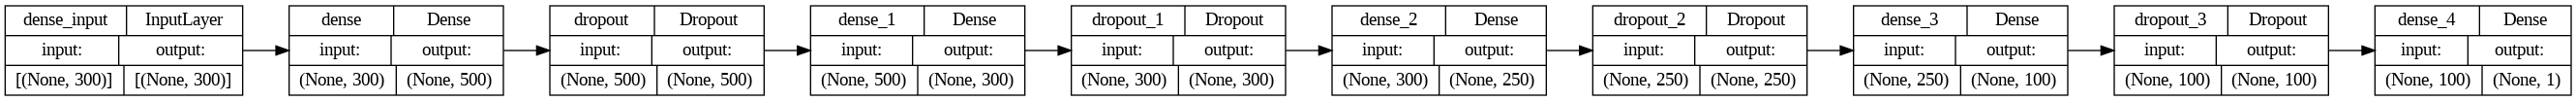

In [ ]:
# show model diagram
plot_model(model, show_shapes=True, rankdir='LR')

In [ ]:
train_data['mean_vector'].shape

(10000,)

In [ ]:
train_data['mean_vector'][0].shape

(300,)

In [ ]:
# Our input data need to have shape [n_samples, features]
mean_vector_array = np.array(train_data['mean_vector'].tolist())
mean_vector_array.shape


(10000, 300)

Fit the data into the model and set the hyperparameters.
* Batch size should be in the range `[32, 250]`
* Epochs should be in the range `[20, 50]`

We are going to use **early stopping** on validation loss for training our network. Early stopping helps prevent overfitting by stopping the training process before the model starts to memorize the training data.

In [ ]:
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

# Our input data need to have shape [n_samples, features]
X_train = np.array(train_data['mean_vector'].tolist())
y_train = train_data['label']

## TODO
model.fit(X_train,
          y_train,
          batch_size = 49,
          epochs = 20,
          validation_split=.2,
          callbacks=[earlyStopping],
          shuffle=True)

Epoch 1/20
164/164 [==============================] - 7s 10ms/step - loss: 0.7575 - accuracy: 0.5836 - val_loss: 0.5115 - val_accuracy: 0.7535
Epoch 2/20
164/164 [==============================] - 1s 5ms/step - loss: 0.5684 - accuracy: 0.7226 - val_loss: 0.4983 - val_accuracy: 0.7730
Epoch 3/20
164/164 [==============================] - 1s 4ms/step - loss: 0.5176 - accuracy: 0.7567 - val_loss: 0.4570 - val_accuracy: 0.7840
Epoch 4/20
164/164 [==============================] - 1s 5ms/step - loss: 0.4789 - accuracy: 0.7784 - val_loss: 0.4414 - val_accuracy: 0.7945
Epoch 5/20
164/164 [==============================] - 1s 5ms/step - loss: 0.4608 - accuracy: 0.7928 - val_loss: 0.4282 - val_accuracy: 0.8070
Epoch 6/20
164/164 [==============================] - 1s 5ms/step - loss: 0.4474 - accuracy: 0.7979 - val_loss: 0.4324 - val_accuracy: 0.7975
Epoch 7/20
164/164 [==============================] - 1s 6ms/step - loss: 0.4418 - accuracy: 0.8011 - val_loss: 0.4135 - val_accuracy: 0.8200
Epoch

The `"sigmoid"` activation function produces continuous output values between 0 and 1. To convert the predicted values to binary, you can use a threshold value. For example, you can set a threshold of 0.5, such that any predicted value above 0.5 is classified as positive (1) and any predicted value below 0.5 is classified as negative (0). You can use the `round` function to apply this threshold.

In [ ]:
X_test = np.array(test_data['mean_vector'].tolist())
y_test = test_data['label']

# TODO: Predict labels of test data
y_pred = model.predict(X_test)

y_pred = y_pred.round()

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

63/63 [==============================] - 0s 2ms/step
Accuracy: 0.84
Precision: 0.8406813627254509
Recall: 0.839


Does it improve the results from the Logistic regression using BoW?

Not really, not very much.

## **Recurrent Neural Network**

Next, we are going to use a LSTM layer into our neural network to learn from long-term dependencies in sequential data.

We need to define a **maximum sequence length** to batchify our data during training and avoid having a lot of padded texts. To make a good decision you will need to look at the distribution of texts lengths of your data.

In [ ]:
train_data.columns

Index(['file_name', 'label', 'text', 'clean_tokens', 'vectors', 'mean_vector',
       'clean_texts'],
      dtype='object')

In [ ]:
sentence_lengths = [len(token) for token in train_data["clean_tokens"]]

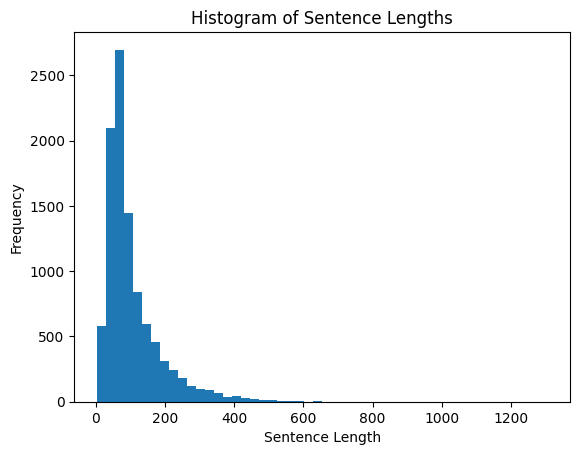

In [ ]:
import matplotlib.pyplot as plt

## TODO: Get lengths of arrays of clean_tokens
#sentence_lengths = train_data["clean_texts"].apply(len)

# Create a histogram of the sentence lengths
plt.hist(sentence_lengths, bins=50)
plt.title("Histogram of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

### **Vectorizer**

Text vectorization Keras layer **transforms a batch of strings** (one sample = one string) **into a list of indices** (one sample = 1D tensor of integer token indices).

The vocabulary to be used can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary. Here, we are going to define a miximum vocabulary size.

*Hint: Reducing the vocabulary size excessively may result in the model missing out on essential information, whereas utilizing the entire vocabulary can lead to an excessive amount of noise. As a general guideline, a vocabulary size of around 10,000 to 20,000 words might be a reasonable starting point for the IMDB dataset.*

*Optional: You can plot a histogram of token frequencies in your dataset. You might find that a large portion of tokens are used very infrequently. You could consider setting a threshold to exclude very rare words from the vocabulary, as they might not contribute much to the model's performance.*

**Define the variables taking into account:**
- `max_words_vocab` defines the maximum amount of words of your dataset to be used.

- `embedding_dim` is the dimension of the words embeddings.
- `seq_length` defines the maximum amount of words to be considered per review.


In [ ]:
## TODO: Definition of constants
max_words_vocab = 20000       # Only consider the top X words
embedding_dim = 300       # Dimension of the embedding
seq_length = 150            # Only consider the first X words of each movie review


## TODO: Fill in the ...
Vectorizer = TextVectorization(
    max_tokens=max_words_vocab,
    standardize=None,
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=seq_length,
    pad_to_max_tokens=False,
    vocabulary=None,
)



The **vocabulary** for the layer must be either supplied on construction or learned via `adapt()`. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a vocabulary from them.

In [ ]:
#fit the vectorizer on the clean text and extract the corpus vocabulary
Vectorizer.adapt(train_data['clean_texts'])
vocab = Vectorizer.get_vocabulary()

In [ ]:
len(vocab)

20000

### **Embedding**

In [ ]:
#generate the embedding matrix
max_features_vocab = 20000


embedding_matrix = np.zeros((max_features_vocab, embedding_dim))
for i, word in enumerate(tqdm_notebook(vocab)):
    embedding_matrix[i] = nlp(str(word)).vector

  0%|          | 0/20000 [00:00<?, ?it/s]

What is the shape of the embedding matrix?

In [ ]:
## TODO
embedding_matrix.shape

(20000, 300)

Now, let's define the embedding layer with initialized pretrained word vectors. Set trainable to `True` to train weights of this layer. You can look at the definition of the class in [Keras documentation](https://keras.io/api/layers/core_layers/embedding/)

In [ ]:
## TODO: Create an embedding layer instance
# Load the embedding matrix as the weights matrix for the embedding layer
from keras.layers import Embedding

# Embedding_layer = Embedding(
#     input_dim=max_words_vocab,
#     output_dim=embedding_dim,
#     embeddings_initializer="uniform",
#     embeddings_regularizer=None,
#     embeddings_constraint=None,
#     mask_zero=False,
#     weights=embedding_matrix,
#     trainable=True)

Embedding_layer = Embedding(
    input_dim=max_words_vocab,
    output_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    embeddings_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    weights=[embedding_matrix],
    trainable=True
)




### Add LSTM

Build the recurrent neural network, considering:
* Input data is a `string`
* Vectorizer transforms `string` into `ints`
* `Embedding` layer for word representations
* A `LSTM` layer with 128 units
* `Dense` layers [64, 32]
* Last layer outputs a value between 0 and 1

In [104]:
## TODO: Build a neural network with a LSTM

# Initialize the sequential model
lstm = Sequential()

# Add the text vectorization layer
lstm.add(Input(shape=(1,), dtype=tf.string))  # Input layer expecting a string
lstm.add(Vectorizer)  # Text vectorization layer

# Add the embedding layer
lstm.add(Embedding_layer)  # Embedding layer

# Add the LSTM layer with 128 units
lstm.add(LSTM(128))

# Add the dense layers
lstm.add(Dense(64, activation='relu'))

lstm.add(Dense(32, activation='relu'))


# Add the final output layer with sigmoid activation
lstm.add(Dense(1, activation='sigmoid'))

# Callbacks
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')


# Compile the model
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
lstm.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 150)               0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 150, 300)          6000000   
                                                                 
 lstm_13 (LSTM)              (None, 128)               219648    
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 1)                 33        
                                                     

In [ ]:
from sklearn.model_selection import train_test_split

In [107]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

X_train, X_val, y_train, y_val = train_test_split(train_data['clean_texts'], train_data['label'], test_size=0.2, random_state=42)

## TODO: Fit the model
history = lstm.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=10,
    callbacks=[earlyStopping],
    shuffle=True
)

Epoch 1/20
800/800 [==============================] - 67s 84ms/step - loss: 0.2879 - accuracy: 0.8951 - val_loss: 0.5234 - val_accuracy: 0.8420
Epoch 2/20
800/800 [==============================] - 22s 27ms/step - loss: 0.2630 - accuracy: 0.9105 - val_loss: 0.4778 - val_accuracy: 0.8560
Epoch 3/20
800/800 [==============================] - 19s 24ms/step - loss: 0.1772 - accuracy: 0.9410 - val_loss: 0.4125 - val_accuracy: 0.8715
Epoch 4/20
800/800 [==============================] - 14s 18ms/step - loss: 0.2832 - accuracy: 0.8765 - val_loss: 0.4367 - val_accuracy: 0.8530
Epoch 5/20
800/800 [==============================] - 14s 17ms/step - loss: 0.1114 - accuracy: 0.9636 - val_loss: 0.4245 - val_accuracy: 0.8740
Epoch 6/20
800/800 [==============================] - 13s 16ms/step - loss: 0.0564 - accuracy: 0.9847 - val_loss: 0.4734 - val_accuracy: 0.8740
Epoch 7/20
800/800 [==============================] - 13s 16ms/step - loss: 0.0377 - accuracy: 0.9910 - val_loss: 0.5487 - val_accuracy:

In [122]:
## TODO: Get predictions from your trained network and compute performance metrics
y_test = test_data['label']

# TODO: Predict labels of test data

y_pred = lstm.predict(test_data["clean_texts"])
y_pred = y_pred.round()


# Model Accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

63/63 [==============================] - 0s 6ms/step
Accuracy: 0.7645
Precision: 0.8190591073582629
Recall: 0.679


We achieved a similar performance than Dense Neural Network with half of the parameters.



## Bidirectional LSTM

Bidirectional LSTMs are an extension of LSTMs. The basic idea behind a bidirectional LSTM is to run two separate LSTM layers on the input sequence, one in the forward direction and one in the backward direction. This allows the network to capture information from both past and future contexts of each input element, and combine them to make better predictions.

Let's implement a neural network with a bidirectional LSTM layer of 128 units and compare the performance with previous networks.

In [116]:
from keras.layers import Bidirectional


In [119]:
## TODO: Implement a neural network with a bidirectional LSTM

# Initialize the sequential model
bi_lstm = Sequential()

# Add the text vectorization layer
bi_lstm.add(Input(shape=(1,), dtype=tf.string))  # Input layer expecting a string
bi_lstm.add(Vectorizer)  # Text vectorization layer

# Add the embedding layer
bi_lstm.add(Embedding_layer)  # Embedding layer

# Add the bidirectional LSTM layer with 128 units
bi_lstm.add(Bidirectional(LSTM(128)))

# Add the dense layers
bi_lstm.add(Dense(64, activation='relu'))

bi_lstm.add(Dense(32, activation='relu'))


# Add the final output layer with sigmoid activation
bi_lstm.add(Dense(1, activation='sigmoid'))

# Callbacks
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')


# Compile the model
bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
bi_lstm.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 150)               0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 150, 300)          6000000   
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dense_44 (Dense)            (None, 64)                16448     
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dense_46 (Dense)            (None, 1)               

In [120]:
## TODO: Fit the model
history = bi_lstm.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=10,
    callbacks=[earlyStopping],
    shuffle=True
)

Epoch 1/20
800/800 [==============================] - 54s 60ms/step - loss: 0.2416 - accuracy: 0.8929 - val_loss: 0.3528 - val_accuracy: 0.8730
Epoch 2/20
800/800 [==============================] - 23s 28ms/step - loss: 0.0757 - accuracy: 0.9732 - val_loss: 0.3922 - val_accuracy: 0.8870
Epoch 3/20
800/800 [==============================] - 20s 25ms/step - loss: 0.0589 - accuracy: 0.9791 - val_loss: 0.5135 - val_accuracy: 0.8600
Epoch 4/20
800/800 [==============================] - 20s 25ms/step - loss: 0.0357 - accuracy: 0.9889 - val_loss: 0.4462 - val_accuracy: 0.8865
Epoch 5/20
800/800 [==============================] - 18s 22ms/step - loss: 0.0253 - accuracy: 0.9921 - val_loss: 0.5263 - val_accuracy: 0.8870
Epoch 6/20
800/800 [==============================] - 18s 23ms/step - loss: 0.0169 - accuracy: 0.9950 - val_loss: 0.6028 - val_accuracy: 0.8795


In [123]:
## TODO: Predict with a test dataset
y_test = test_data['label']

# TODO: Predict labels of test data

y_pred = lstm.predict(test_data["clean_texts"])
y_pred = y_pred.round()

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

63/63 [==============================] - 0s 6ms/step
Accuracy: 0.7645
Precision: 0.8190591073582629
Recall: 0.679


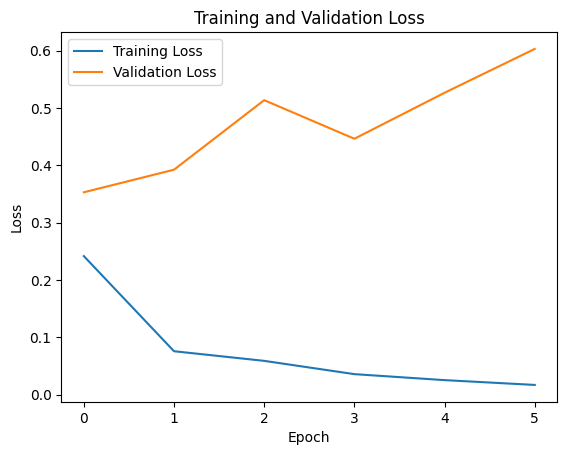

In [124]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()